# Trabalho Prático 1
**Grupo 22**

Alexis Correia - A102495 <br>
João Fonseca - A102512


## Exercício 2
Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido .  O grafo tem de ser ligado: entre cada par de nodos  $(n_1,n_2)$ tem de existir um caminho $n_1 -> n_2$ e um caminho $n_2 -> n_1$.

1. Gerar aleatoriamente o grafo com  $N \in \{6..10\}$  nodos e com ramos verificando:
    1. Cada nodo tem um número aleatório de descendentes $d \in \{0..3\}$, cujos destinos são também gerados aleatoriamente.
    2. Se  existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.
    
2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

In [1]:
#Inicialização

import networkx as nx
import random

{0: [8, 4, 6], 1: [2, 4], 2: [1, 5], 3: [5, 6], 4: [7], 5: [2, 3], 6: [0, 3], 7: [8, 1, 4], 8: [0, 7]}


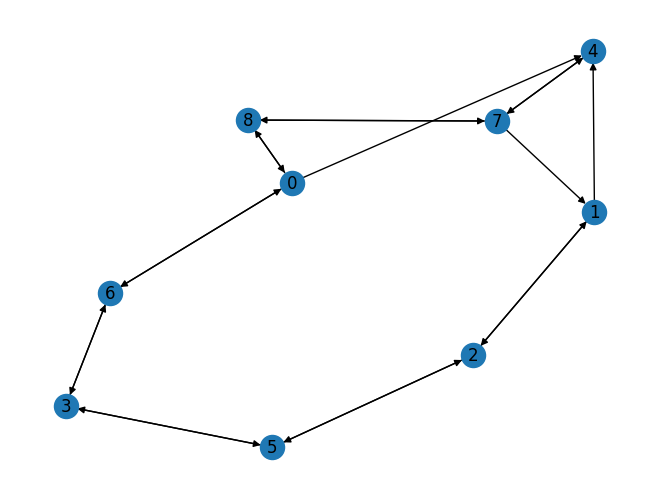

In [30]:
random.seed(None)

def cria_adj(N):
    adj = {n: [] for n in range(N)}
    nodes = list(range(N))
    random.shuffle(nodes)
    
    for i in range(N - 1):
        adj[nodes[i]].append(nodes[i + 1])
        adj[nodes[i + 1]].append(nodes[i])

    for n in range(N):
        num_arestas = random.randint(0, 1)
        for _ in range(num_arestas):
            d = random.randint(0, N - 1)
            if d != n and d not in adj[n]:
                adj[n].append(d)
    
    for n in adj:
        adj[n] = list(set(adj[n]))
    
    return adj

N = 9
adj = cria_adj(N)
print(adj)

def converte(adj):
    graph = nx.DiGraph()
    for n in adj.keys():
        graph.add_node(n)
        for i in adj[n]:
            graph.add_edge(n, i)
    return graph

G = converte(adj)
nx.draw(G, with_labels=True)